<a href="https://colab.research.google.com/github/aim97/Neural-networks/blob/master/Tensorflow/FunctionalAPI-enenrgy%2Befficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow Functional API

Tensorflow adds more flexibility of defining the model using its functional API.

If your model is simply staking layers on top of one another, you only need to use `Sequential` Model, which will do the job for you. However if your code is more complicated taking different paths, and then rejoining, or having multiple different outputs, the usual sequential model wouldn't cut it and you would need a more flexible way to define your model.  

That's where the functional API comes for the rescue, it allows you to connect layers manually rather than having Sequential connect them for you, which allows you to connect your neural network in all sorts of ways.  

In order to build such model, Tensorflow requires you to provide 2 Things:

1. The model input(s).
2. The model output(s).

and provide them to `Model` class constructor, then from this point forward everything is like how it's done with Sequential.


In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
import numpy as np

What you need to understand is mainly how to connect layer with the functional API.  
```python
layer2_output = LayerConstructor( ...layer_parameters ) (layer1_output)
```

You form a connection better two layers in this way.

In [3]:
xs = Input((8,), name='model_input')
x = Dense(128, activation='relu', name='first')(xs)
x = Dense(128, activation='relu', name='second')(x)

y1 = Dense(1, name='y1_output')(x);
y2_path = Dense(64, activation='relu', name='another_path')(x)

y2 = Dense(1, name='y2_output')(y2_path)

In [4]:
model = tf.keras.Model(inputs=[xs], outputs=[y1, y2])  # when you have multiple output specifiy them all
# notice the names of the layers displayed in the summary
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
model_input (InputLayer)        [(None, 8)]          0                                            
__________________________________________________________________________________________________
first (Dense)                   (None, 128)          1152        model_input[0][0]                
__________________________________________________________________________________________________
second (Dense)                  (None, 128)          16512       first[0][0]                      
__________________________________________________________________________________________________
another_path (Dense)            (None, 64)           8256        second[0][0]                     
______________________________________________________________________________________________

Note: with Tensorflow functional API, when you have multiple outputs, giving the output layer a name is important, actually it's a good practice to give each layer a unique (it has to be unique) name to identify it.  

1. It makes it easier to understand the model summary and model graph.
2. Multiple parts of tensorflow API use those names, for instance, in our case we want to define different loss and metrics of performance for each output we have, we provide a dictionary with the output layers **names** as keys.

```python
model.compile(
    optimizer=optimizer,
    loss={
        'y1_output': 'mse', 
        'y2_output': 'mse'
    },
    metrics={
        'y1_output': tf.keras.metrics.RootMeanSquaredError(),
        'y2_output': tf.keras.metrics.RootMeanSquaredError()
    }
)
```

You can also use a list to do the job which will depend on the order the outputs appear in the outputs list provided to the model constructor, but using a dictionary provides higher readability.

In [5]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss=[
        'mse', 
        'mse'
    ],
    metrics=[
        [tf.keras.metrics.RootMeanSquaredError()],
        [tf.keras.metrics.RootMeanSquaredError()]
    ]
)

We use sklearn `train_test_split` to split our dataset with a given ratio.

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [7]:
# read the energy + efficiency data set from its URL
dataset = pd.read_excel('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx');
# suffule the dataset, then reset the index column since we don't want it suffuled as well.
dataset = dataset.sample(frac=1).reset_index(drop=True)

## Some Cleanup

Aside from splitting the dataset into training and testing sets, we also need to split it into input and output, which is done by the `format_output` helper function.

In [8]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)
    return y1, y2


def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


In [9]:
# Split the data into train and test with 80 train / 20 test
train, test = train_test_split(dataset, test_size=0.2)
train_stats = train.describe()

# Get Y1 and Y2 as the 2 outputs and format them as np arrays
train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y = format_output(test)

# Normalize the training and test data
norm_train_X = norm(train)
norm_test_X = norm(test)

In [10]:
# Train the model for 500 epochs
history = model.fit(
    norm_train_X, 
    np.array(train_Y).T,
    epochs=500, 
    batch_size=10, 
    validation_data=(norm_test_X, test_Y)
)

Epoch 1/500
62/62 [==============================] - 2s 8ms/step - loss: 238.5815 - y1_output_loss: 126.2309 - y2_output_loss: 112.3506 - y1_output_root_mean_squared_error: 11.2353 - y2_output_root_mean_squared_error: 10.5996 - val_loss: 71.0435 - val_y1_output_loss: 24.2798 - val_y2_output_loss: 46.7637 - val_y1_output_root_mean_squared_error: 4.9275 - val_y2_output_root_mean_squared_error: 6.8384
Epoch 2/500
62/62 [==============================] - 0s 3ms/step - loss: 33.0037 - y1_output_loss: 14.6073 - y2_output_loss: 18.3963 - y1_output_root_mean_squared_error: 3.8220 - y2_output_root_mean_squared_error: 4.2891 - val_loss: 32.3142 - val_y1_output_loss: 14.4419 - val_y2_output_loss: 17.8723 - val_y1_output_root_mean_squared_error: 3.8002 - val_y2_output_root_mean_squared_error: 4.2276
Epoch 3/500
62/62 [==============================] - 0s 3ms/step - loss: 29.6875 - y1_output_loss: 13.0723 - y2_output_loss: 16.6152 - y1_output_root_mean_squared_error: 3.6156 - y2_output_root_mean_sq

In [11]:
# Test the model and print loss and mse for both outputs
loss, Y1_loss, Y2_loss, Y1_rmse, Y2_rmse = model.evaluate(x=norm_test_X, y=test_Y)
print("Loss = {}, Y1_loss = {}, Y1_mse = {}, Y2_loss = {}, Y2_mse = {}".format(loss, Y1_loss, Y1_rmse, Y2_loss, Y2_rmse))

5/5 [==============================] - 0s 3ms/step - loss: 6.0626 - y1_output_loss: 2.9252 - y2_output_loss: 3.1374 - y1_output_root_mean_squared_error: 1.7103 - y2_output_root_mean_squared_error: 1.7713
Loss = 6.062577724456787, Y1_loss = 2.925175189971924, Y1_mse = 1.710314393043518, Y2_loss = 3.1374025344848633, Y2_mse = 1.7712714672088623


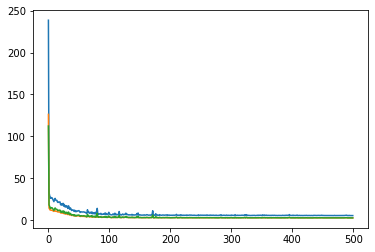

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss']);
plt.plot(history.history['y1_output_loss']);
plt.plot(history.history['y2_output_loss']);

In [14]:
print(history.history.keys())

dict_keys(['loss', 'y1_output_loss', 'y2_output_loss', 'y1_output_root_mean_squared_error', 'y2_output_root_mean_squared_error', 'val_loss', 'val_y1_output_loss', 'val_y2_output_loss', 'val_y1_output_root_mean_squared_error', 'val_y2_output_root_mean_squared_error'])


# Siamese network

It's a sub model that recieves multiple inputs, and uses the same weights for all of them, in the image below, you can see two identical parts of the model, marked as having shared weights, in code we use one network and simply pass the two inputs through it.  
![Siamese network example](../images/Siamese-network-example.png)


In [47]:
from tensorflow.keras.layers import Flatten, Dropout, Lambda
import tensorflow.keras.backend as K

In [48]:
# construct a Siamese network with shared weights
# The input is 28x28 images.
# The output is a vector of size 128.
def siamese_network(prefex=''):
  xs = Input((28, 28), name=prefex+'input')
  x = Flatten(name=prefex+'_Flatten')(xs)
  x = Dense(128, activation='relu', name=prefex+'_D1')(x)
  x = Dropout(0.1, name=prefex+'_D1_dropout')(x)
  x = Dense(128, activation='relu', name=prefex+'_D2')(x)
  x = Dropout(0.1, name=prefex+'_D2_dropout')(x)
  x = Dense(128, activation='relu', name=prefex+'_D3')(x)
  return tf.keras.Model(inputs=[xs], outputs=[x])

In [49]:
# Construct the model that uses the Siamese network
# create two inputs for the siamese network
left_input = Input((28, 28), name='left_input')
right_input = Input((28, 28), name='right_input')

# create the siamese network
siamese_net = siamese_network('siamese_')

# create the outputs of the siamese network
left_output = siamese_net(left_input)
right_output = siamese_net(right_input)


In [50]:
# define euclidean distance function
def euclidean_distance(vects):
  x, y = vects
  return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def eucl_dist_output_shape(shapes):
  shape1, shape2 = shapes
  return (shape1[0], 1)

In [51]:

# merge the outputs of the siamese network with euclidean distance
euclidean_distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([left_output, right_output])

# and create the final model
model = tf.keras.Model(inputs=[left_input, right_input], outputs=[euclidean_distance])

In [52]:
# show Siamese network architecture and summary
print(siamese_net.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
siamese_input (InputLayer)   [(None, 28, 28)]          0         
_________________________________________________________________
siamese__Flatten (Flatten)   (None, 784)               0         
_________________________________________________________________
siamese__D1 (Dense)          (None, 128)               100480    
_________________________________________________________________
siamese__D1_dropout (Dropout (None, 128)               0         
_________________________________________________________________
siamese__D2 (Dense)          (None, 128)               16512     
_________________________________________________________________
siamese__D2_dropout (Dropout (None, 128)               0         
_________________________________________________________________
siamese__D3 (Dense)          (None, 128)               1651

In [53]:
# show the model architecture
print(model.summary())
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
left_input (InputLayer)         [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
right_input (InputLayer)        [(None, 28, 28)]     0                                            
__________________________________________________________________________________________________
model_2 (Functional)            (None, 128)          133504      left_input[0][0]                 
                                                                 right_input[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1)            0           model_2[0][0]              

In [54]:
# Specify the optimizer, and compile the model with loss functions for both outputs
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

In [55]:
# Contrastive loss function (we will address this in a future post)
def contrastive_loss_with_margin(margin):
  def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
  return contrastive_loss

In [56]:
# Compile the model
model.compile(
  optimizer=optimizer,
  loss=[contrastive_loss_with_margin(margin=1.0)]
)

# Shall we load the data?

The data we will work with is the Fashion MNIST dataset, which is a dataset of 60,000 grayscale images of size 28x28 pixels.  

The model we are trying to build should output the distance between the images, namely a pair of images from Fashion MNIST dataset; so we need to reformat the images into pairs with a label of 1 if they are from the same class and 0 otherwise.

we want the data in the format

image_1 | image_2 | label
--------|---------|--------
0.png   | 1.png   | 1
0.png   | 2.png   | 0
 ....   | ....    | ....

In [26]:
# load the dataset
from tensorflow.keras.datasets import fashion_mnist

(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

In [27]:
# Some preprocessing
def preprocess(x):
  x = x.reshape(x.shape[0], 28, 28).astype('float32')
  x /= 255
  return x

In [28]:
train_X = preprocess(train_X)
test_X = preprocess(test_X)

# Making pairs

Splitting the dataset into pairs should be an easy two nested loops, or may be you can do it easier, but anyway, this will give us more data than we need, and will be too time consuming, instead we will try to limit the number of pairs we have by some restrictions:

1. if N is the size of smallest class, then we can have 2(N - 1) pairs for each class.
2. Half of the pairs per class should be of the same class, hence will be labeled as 1 `match`.
3. the other half of pairs will be made of one image of current class, and another from another randomly selected class, hence will be labeled as 0 `mismatch`.

In [43]:
# reformat the data into pairs of images
def reformat(images, labels):
  # get size of smallest class
  min_class_size = min(np.bincount(labels)) - 1
  print(min_class_size)
  pairs = []            # list of image pairs
  areMatching = []      # list of match/missMatch labels

  class_indices = [np.where(labels == i)[0] for i in range(10)]
    
  for cur_class in range(10):
    for i in range(min_class_size):
      # the current image index is the ith image within the current class
      cur_image_index = class_indices[cur_class][i]
      # and the matching image is the one after it within the same class
      matching_image_index = class_indices[cur_class][i + 1]

      # add matching pairs
      cur_image = images[cur_image_index]
      matching_image = images[matching_image_index]

      pairs.append([cur_image, matching_image])
      areMatching.append(1)

      # add non-matching images
      random_class = np.random.randint(0, 9)

      # random image index is the ith image within the random class, so that the result is deterministic
      random_image_index = class_indices[random_class][i]
      non_matching_image = images[random_image_index]

      pairs.append([cur_image, non_matching_image])
      areMatching.append(0)
  
  return np.array(pairs), np.array(areMatching, dtype=np.float32)

In [44]:
# reformat the dataset into pairs of images
train_pairs, train_distance = reformat(train_X, train_y)
test_pairs, test_distance = reformat(test_X, test_y)

5999
999


In [ ]:
# # Show some examples of the training data
# %matplotlib inline
# import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec

# # pick 4 random pairs from the training set
# random_indices = np.random.randint(0, len(train_pairs), size=4)
# random_pairs = train_pairs[random_indices]
# random_distance = train_distance[random_indices]

# fig = plt.figure(figsize=(20, 10))
# outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)

# for i in range(4):
#   inner = gridspec.GridSpecFromSubplotSpec(1, 2,
#                   subplot_spec=outer[i], wspace=0.1, hspace=0.1)

#   for j in range(2):
#     ax = plt.Subplot(fig, inner[j])
    
#     # show the image
#     ax.imshow(random_pairs[i][j])

#     # show the label
#     ax.text(0, 0, '{}'.format(random_distance[i]),
#             size=24, ha='center', va='center', color='w')

#     ax.set_xticks([])
#     ax.set_yticks([])
#     fig.add_subplot(ax)



# fig.show()


<ipython-input-85-5ab368570464>:37: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


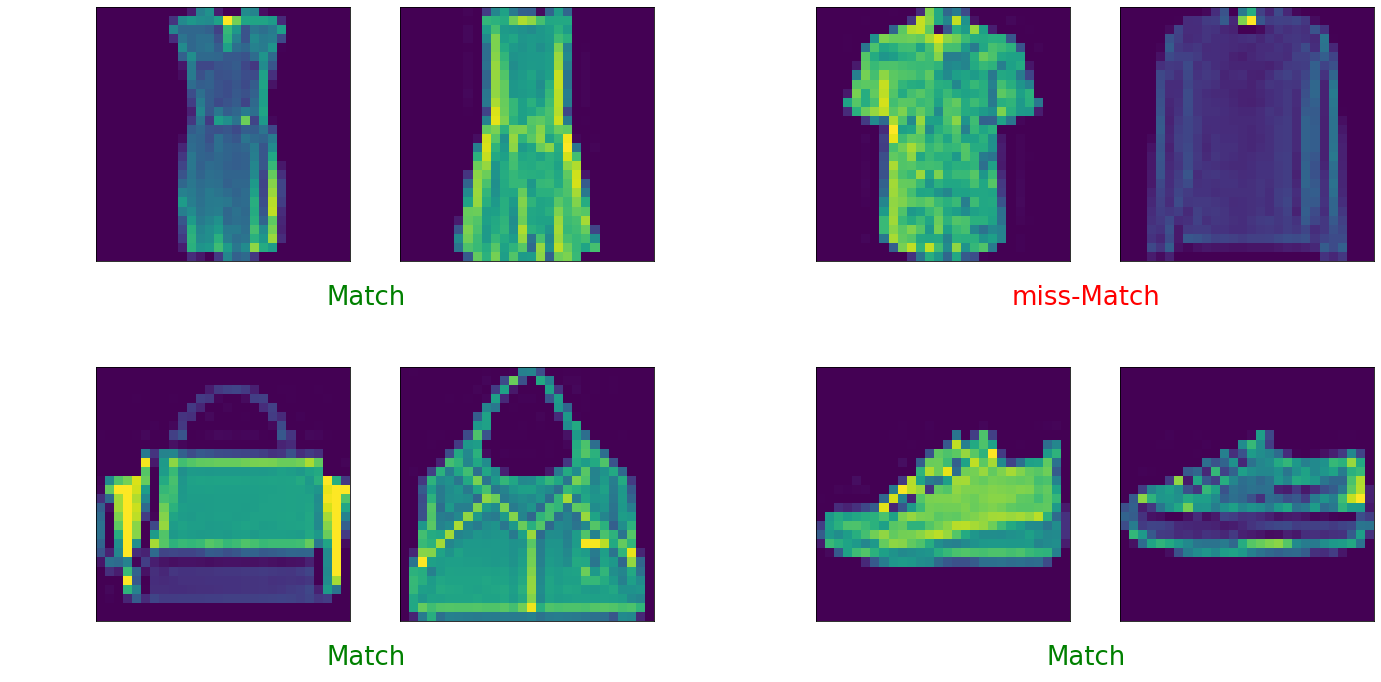

In [85]:
# Show some examples of the training data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# pick 4 random pairs from the training set
random_indices = np.random.randint(0, len(train_pairs), size=4)
random_pairs = train_pairs[random_indices]
random_distance = train_distance[random_indices]

fig = plt.figure(figsize=(20, 10))

subFigs = fig.subfigures(2, 2).flatten()

for i in range(4):
  subFig = subFigs[i]
  label = "Match" if random_distance[i] else "miss-Match"
  color = "green" if random_distance[i] else "red"
  subFig.supxlabel(label, fontsize=26, color=color)

  axs = subFig.subplots(1, 2)

  for j in range(2):
    ax = axs[j]
    
    # show the image
    ax.imshow(random_pairs[i][j])

    # show the label
    # ax.text(0, 0, '{}'.format(random_distance[i]),
    #         size=24, ha='center', va='center', color='w')

    ax.set_xticks([])
    ax.set_yticks([])
    subFig.add_subplot(ax)

fig.show()


# How does a siamese network train


In [58]:
# Train the model
history = model.fit(
  x=[train_pairs[:, 0], train_pairs[:, 1]],
  y=train_distance,
  validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_distance),
  batch_size=128,
  epochs=10,
  verbose=1
)

Epoch 1/10
938/938 [==============================] - 7s 7ms/step - loss: 0.1003 - val_loss: 0.1133
Epoch 2/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0996 - val_loss: 0.1107
Epoch 3/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0986 - val_loss: 0.1117
Epoch 4/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0982 - val_loss: 0.1117
Epoch 5/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0975 - val_loss: 0.1116
Epoch 6/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0969 - val_loss: 0.1115
Epoch 7/10
938/938 [==============================] - 7s 8ms/step - loss: 0.0966 - val_loss: 0.1101
Epoch 8/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0962 - val_loss: 0.1088
Epoch 9/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0955 - val_loss: 0.1116
Epoch 10/10
938/938 [==============================] - 7s 7ms/step - loss: 0.0954 - val_loss: 0.1107

In [59]:
# evaluate the model, don't forget the history!
print(model.evaluate(x=[test_pairs[:, 0], test_pairs[:, 1]], y=test_distance, verbose=1))

625/625 [==============================] - 1s 2ms/step - loss: 0.1107
0.11073468625545502


<ipython-input-88-858dd6455cc9>:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


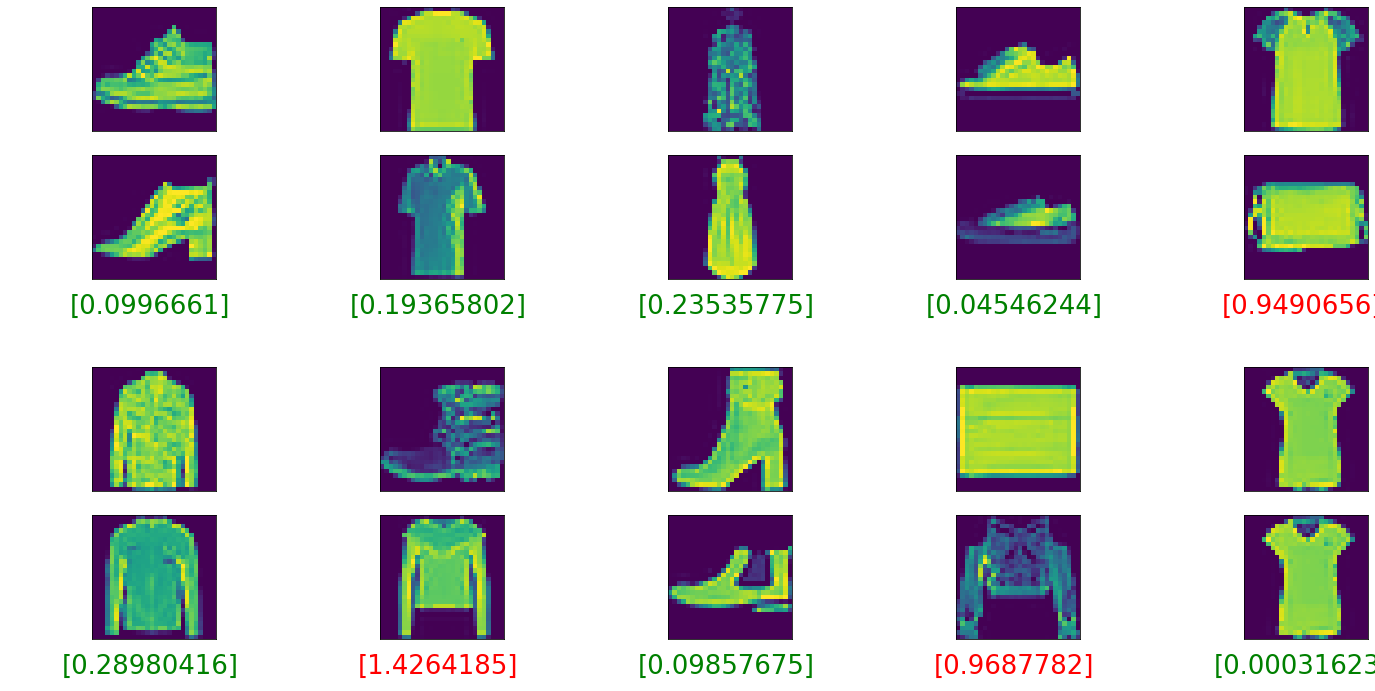

In [88]:
# let's do some plots!
import matplotlib.pyplot as plt

# pick 4 random pairs from the test set
random_indices = np.random.randint(0, len(test_pairs), size=10)
random_pairs = test_pairs[random_indices]

# predict the distance for each pair
predictions = model.predict([random_pairs[:, 0], random_pairs[:, 1]])

# plot the results
fig = plt.figure(figsize=(20, 10))

subFigs = fig.subfigures(2, 5).flatten()

for i in range(10):
  subFig = subFigs[i]
  distance = predictions[i]
  color = "green" if distance < 0.5 else "red"
  subFig.supxlabel(distance, fontsize=26, color=color)

  axs = subFig.subplots(2, 1)

  for j in range(2):
    ax = axs[j]
    
    # show the image
    ax.imshow(random_pairs[i][j])

    # show the label
    # ax.text(0, 0, '{}'.format(random_distance[i]),
    #         size=24, ha='center', va='center', color='w')

    ax.set_xticks([])
    ax.set_yticks([])
    subFig.add_subplot(ax)

fig.show()